# 1. Library and data importation

In [277]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

/kaggle/input/koncentracije-ambrozije/submission_example.csv
/kaggle/input/koncentracije-ambrozije/pollen_train.csv
/kaggle/input/koncentracije-ambrozije/pollen_test.csv
/kaggle/input/koncentracije-ambrozije/pollen-type.csv
/kaggle/input/koncentracije-ambrozije/weather_data.csv


Data importation

In [278]:
pollen_type = pd.read_csv("/kaggle/input/koncentracije-ambrozije/pollen-type.csv")
pollen_type = pollen_type.drop(pollen_type.columns[0],axis=1)
#pollen_type = pollen_type.set_index(pollen_type.columns[0])
pollen_train = pd.read_csv("/kaggle/input/koncentracije-ambrozije/pollen_train.csv")
pollen_train = pollen_train.drop(pollen_train.columns[0],axis=1)
#pollen_train = pollen_train.set_index(pollen_train.columns[0])
weather = pd.read_csv("/kaggle/input/koncentracije-ambrozije/weather_data.csv")
weather = weather.drop(weather.columns[0],axis=1)
#weather = weather.set_index(weather.columns[0])
pollen_test = pd.read_csv("/kaggle/input/koncentracije-ambrozije/pollen_test.csv")
submission_example = pd.read_csv("/kaggle/input/koncentracije-ambrozije/submission_example.csv")

# 2. Data preprocessing

Check for null and categorical values

In [75]:
print(pollen_train.isnull().sum())
pollen_train.shape

location         0
date             0
ACER             0
ALNUS            0
AMBROSIA         0
ARTEMISIA        0
BETULA           0
CANNABACEAE      0
CARPINUS         0
CELTIS           0
CHENOP/AMAR.     0
CORYLUS          0
CUPRESS/TAXA.    0
FAGUS            0
FRAXINUS         0
JUGLANS          0
MORACEAE         0
PINACEAE         0
PLANTAGO         0
PLATANUS         0
POACEAE          0
POPULUS          0
QUERCUS          0
RUMEX            0
SALIX            0
TILIA            0
ULMACEAE         0
URTICACEAE       0
dtype: int64


(11254, 28)

In [76]:
print(pollen_type.isnull().sum())
pollen_type.shape

IME_VRSTE_LAT          0
IME_VRSTE_SRB          0
GRUPA_BILJAKA          0
ALERGENI_POTENCIJAL    0
dtype: int64


(25, 4)

In [79]:
print(weather.isnull().sum())
weather.shape

location        0
date            0
tavg         1771
tmin         1793
tmax         1788
prcp         9181
snow        17492
wdir         5832
wspd         3892
wpgt        10974
pres         4142
tsun        17899
dtype: int64


(17899, 12)

Here we checked what values are categorical

In [81]:
for i in range(pollen_train.shape[1]):
    print(pollen_train.iloc[:,i].dtype.name, " ", pollen_train.columns[i])

object   location
object   date
int64   ACER
int64   ALNUS
int64   AMBROSIA
int64   ARTEMISIA
int64   BETULA
int64   CANNABACEAE
int64   CARPINUS
int64   CELTIS
int64   CHENOP/AMAR.
int64   CORYLUS
int64   CUPRESS/TAXA.
int64   FAGUS
int64   FRAXINUS
int64   JUGLANS
int64   MORACEAE
int64   PINACEAE
int64   PLANTAGO
int64   PLATANUS
int64   POACEAE
int64   POPULUS
int64   QUERCUS
int64   RUMEX
int64   SALIX
int64   TILIA
int64   ULMACEAE
int64   URTICACEAE


In [82]:
for i in range(pollen_type.shape[1]):
    print(pollen_type.iloc[:,i].dtype.name, " ", pollen_type.columns[i])

object   IME_VRSTE_LAT
object   IME_VRSTE_SRB
object   GRUPA_BILJAKA
int64   ALERGENI_POTENCIJAL


In [83]:
for i in range(weather.shape[1]):
    print(weather.iloc[:,i].dtype.name, " ", weather.columns[i])

object   location
object   date
float64   tavg
float64   tmin
float64   tmax
float64   prcp
float64   snow
float64   wdir
float64   wspd
float64   wpgt
float64   pres
float64   tsun


These are all the unique values for the location which we to one hot encode

In [85]:
pollen_train['location'].unique()

array(['БЕОГРАД - НОВИ БЕОГРАД', 'ВРШАЦ', 'КРАГУЈЕВАЦ', 'КРАЉЕВО', 'НИШ',
       'ПОЖАРЕВАЦ', 'СУБОТИЦА'], dtype=object)

One hot encoding the locations

In [279]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
index = pollen_train.columns.get_loc('location')
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(pollen_train[['location']]))
OH_cols_train.columns = pollen_train['location'].unique()
pollen_train_without_location = pollen_train.drop('location', axis=1)
pollen_train_encoded = pd.concat([pollen_train_without_location, OH_cols_train], axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Splitting the date into multiple columns (year,month,day) and making them into numbers

In [280]:
def date_transform(data):
    # Split the 'date' column into 'year', 'month', and 'day'
    data[['year', 'month', 'day']] = data['date'].str.split('-', expand=True)

    # Convert 'year,' 'month,' and 'day' columns to integer format
    data['year'] = data['year'].astype(int)
    data['month'] = data['month'].astype(int)
    data['day'] = data['day'].astype(int)

    data.drop('date', axis=1, inplace=True)
    return data

Calling the data split function on the previously one hot encoded data

In [281]:
pollen_train_encoded_full = date_transform(pollen_train_encoded)

Here we observed different pollens to see if they have corellation with ambrosia

In [105]:
print(pollen_train_encoded['ACER'].mean())
print(pollen_train_encoded['ALNUS'].mean())
print(pollen_train_encoded['AMBROSIA'].mean())
print(pollen_train_encoded['ARTEMISIA'].mean())
print(pollen_train_encoded['BETULA'].mean())
print(pollen_train_encoded['CANNABACEAE'].mean())
print(pollen_train_encoded['CARPINUS'].mean())
print(pollen_train_encoded['CELTIS'].mean())
print(pollen_train_encoded['CHENOP/AMAR.'].mean())
print(pollen_train_encoded['CUPRESS/TAXA.'].mean())
print(pollen_train_encoded['FAGUS'].mean())
print(pollen_train_encoded['FRAXINUS'].mean())
print(pollen_train_encoded['JUGLANS'].mean())
print(pollen_train_encoded['MORACEAE'].mean())
print(pollen_train_encoded['PINACEAE'].mean())
print(pollen_train_encoded['PLANTAGO'].mean())
print(pollen_train_encoded['POPULUS'].mean())
print(pollen_train_encoded['QUERCUS'].mean())
print(pollen_train_encoded['RUMEX'].mean())
print(pollen_train_encoded['SALIX'].mean())
print(pollen_train_encoded['TILIA'].mean())
print(pollen_train_encoded['ULMACEAE'].mean())
print(pollen_train_encoded['URTICACEAE'].mean())

3.5868135773947043
2.071885551803803
24.554824951128488
1.3284165629998224
14.774657899413542
2.309756531011196
4.4218055802381375
0.42615958770215034
1.331704282921628
13.681713168651147
0.9656122267638173
3.795983650257686
4.30486937977608
9.79989337124578
5.323085125288786
1.023102896747823
4.08716900657544
4.566465256797583
0.5977430247023281
4.154611693620046
1.3660031988626267
2.344677448018482
22.426070730406966


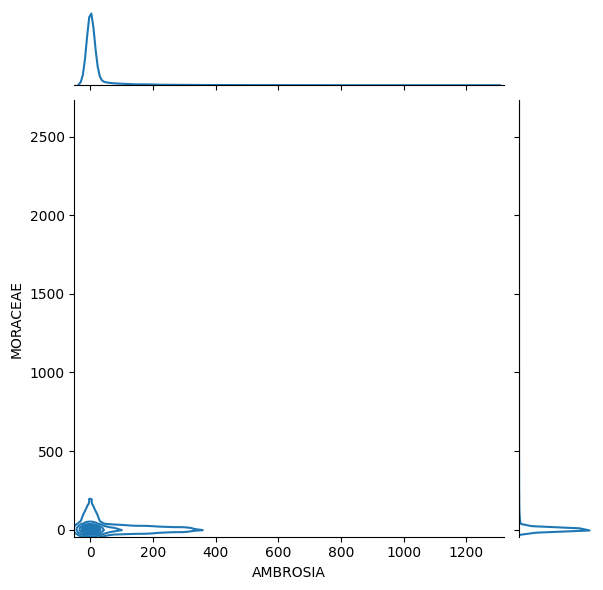

In [475]:
import seaborn as sns
sns.jointplot(x=pollen_train_encoded['AMBROSIA'], y=pollen_train_encoded['MORACEAE'], kind="kde")

Dropping out some of the pollens which we thought to have lower correlation with Ambrosia

In [282]:
pollen_train_encoded_full = pollen_train_encoded_full.drop(columns=['ULMACEAE','RUMEX','CELTIS','ALNUS','TILIA','SALIX','PINACEAE','MORACEAE','FAGUS','CARPINUS'],axis=1)

Also we dropped the columns year and day because they're not very relevant. The column month is more relevant because ambrosia usually occurs in August and September.

In [ ]:
pollen_train_encoded_full = pollen_train_encoded_full.drop(columns=['year','day'],axis=1)

## Train test split

Here we gave 90% of the data to the training and only 10% for evaluation.

In [265]:
split_rate = 0.1
train = pollen_train_encoded_full.iloc[:int(round(len(pollen_train_encoded_full)*(1-split_rate))),:]
val = pollen_train_encoded_full.iloc[int(round(len(pollen_train_encoded_full)*(1-split_rate))):,:]

We inspected the leftover columns.

In [491]:
train.columns

Index(['ALNUS', 'AMBROSIA', 'ARTEMISIA', 'BETULA', 'CELTIS', 'CHENOP/AMAR.',
       'CORYLUS', 'CUPRESS/TAXA.', 'FRAXINUS', 'JUGLANS', 'PLANTAGO',
       'PLATANUS', 'POACEAE', 'POPULUS', 'QUERCUS', 'RUMEX', 'URTICACEAE',
       'БЕОГРАД - НОВИ БЕОГРАД', 'ВРШАЦ', 'КРАГУЈЕВАЦ', 'КРАЉЕВО', 'НИШ',
       'ПОЖАРЕВАЦ', 'СУБОТИЦА', 'month'],
      dtype='object')

## Creating data batches

Here we took 10 of the rows(days) for prediction(labels) and the next 3 row's(days) amount of ambrosia after that are what we are predicting.<br>
We also checked if all those 13 days are measured in the same location otherwise it wouldn't make sense to predict data measured from different locations.

In [285]:
train_x = []
train_Y = []
val_x = []
val_Y = []

for i in range(len(train)-12):
    
    #Check if the 13 days we're taking are from the same location
    to_continue = False
    for j in range(16,23):
        if train.iat[i,j] != train.iat[i+12,j]:
            to_continue = True
    if to_continue:
        continue
    
    batch = train[i:i+10]
    prediction = train[i+10:i+13]['AMBROSIA']
    
    train_x.append(batch)
    train_Y.append(prediction)
    
for i in range(len(val)-12):
    
    #Check if the 13 days we're taking are from the same location
    to_continue = False
    for j in range(16,23):
        if val.iat[i,j] != val.iat[i+12,j]:
            to_continue = True
    if to_continue:
        continue
    
    batch = val[i:i+10]
    prediction = val[i+10:i+13]['AMBROSIA']
    
    val_x.append(batch)
    val_Y.append(prediction)

We lost some of the data due to checking if the data is from the same location.

In [404]:
print(len(train_Y))
print(len(train_x))
print(len(val_x))
print(len(val_Y))
print(len(val_x)+len(train_x))
print(len(pollen_train_encoded_full))

9673
9673
1065
1065
10738
11254


## Normalization

We ended up skipping normalization due to the time we had on this hackathon.

# 3. Model

First we flattened the 2D batches into arrays so we could feed it to our RandomForrestRegressor.

In [286]:
train_x_flattened = []
for i in range(len(train_x)):
    train_x_flattened.append(train_x[i].values.flatten())

In [287]:
val_x_flattened = []
for i in range(len(val_x)):
    val_x_flattened.append(val_x[i].values.flatten())

## Random Forest Regressor approach

In [289]:
trees = 48
model = RandomForestRegressor(n_estimators = trees, random_state = 48)
model.fit(train_x_flattened,train_Y) 

RandomForestRegressor(n_estimators=48, random_state=48)

We also checked MAE for different tree amounts.

In [27]:
def get_mae(trees):
    model = RandomForestRegressor(n_estimators = trees, random_state = 1)
    model.fit(train_x_flattened,train_Y) 
    prediction = model.predict(val_x_flattened)
    print(mean_absolute_error(val_Y, prediction))

for i in [125,150]:
    print('mae for')
    print(i)
    print(get_mae(i))

mae for
125
10.844271674491393
None
mae for
150
10.822184663536781
None


## XGBoost

We tried the XGBoost but it didn't give better results.

In [184]:
model = XGBRegressor()
model.fit(train_x_flattened, train_Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Model evaluation

Here we got the MAE for the selected approach which wasn't too accurate since we used only 10% of data for evaluation so we could train the model to a bigger amount of data.

In [ ]:
prediction = model.predict(val_x_flattened)
print(mean_absolute_error(val_Y, prediction))

# 4. Model submission

Here we took the steps to clean and preprocess the test data as well so we could predict on it and output a prediction for submission to the hackathon.

In [271]:
test_dataset = pollen_test
test_dataset = test_dataset.drop(test_dataset.columns[0],axis=1)

In [272]:
index = test_dataset.columns.get_loc('location')
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_dataset[['location']]))
OH_cols_test.columns = test_dataset['location'].unique()
test_dataset_without_location = test_dataset.drop('location', axis=1)
test_dataset_encoded = pd.concat([test_dataset_without_location, OH_cols_test], axis=1)


In [273]:
test_dataset_encoded = date_transform(test_dataset_encoded)
test_dataset_encoded = test_dataset_encoded.drop(columns=['year','day'],axis=1)
print(test_dataset_encoded.tail())

      ACER  ALNUS  AMBROSIA  ARTEMISIA  BETULA  CANNABACEAE  CARPINUS  CELTIS  \
1115     0      0         4          0       0            3         0       0   
1116     0      0         3          1       0            1         0       0   
1117     0      0         2          1       0            0         0       0   
1118     0      0         7          0       0            0         0       0   
1119     0      0         2          0       0            0         0       0   

      CHENOP/AMAR.  CORYLUS  ...  URTICACEAE  batch_id  \
1115             0        0  ...           2       112   
1116             2        0  ...           0       112   
1117             0        0  ...           0       112   
1118             0        0  ...           0       112   
1119             0        0  ...           0       112   

      БЕОГРАД - НОВИ БЕОГРАД  ВРШАЦ  КРАГУЈЕВАЦ  КРАЉЕВО  НИШ  ПОЖАРЕВАЦ  \
1115                     0.0    0.0         0.0      0.0  0.0        0.0   
1116        

In [274]:
test_dataset_encoded = test_dataset_encoded.drop(columns=['ULMACEAE','RUMEX','CELTIS','ALNUS','TILIA','SALIX','PINACEAE','MORACEAE','FAGUS','CARPINUS'],axis=1)

## Creating data batches for test dataset based on batch_id

In [275]:
# go through dataset and create batches for each batch_id
test_x = []
# find min and max batch_id
min_batch_id = test_dataset_encoded['batch_id'].min()
max_batch_id = test_dataset_encoded['batch_id'].max()

for i in range(min_batch_id, max_batch_id+1):
    batch = test_dataset_encoded[test_dataset_encoded['batch_id'] == i]
    test_x.append(batch)

# drop batch_id column
for i in range(len(test_x)):
    test_x[i] = test_x[i].drop('batch_id', axis=1)


This step outputs a solution.csv prediction for submission.

In [276]:
test_x_flattened = []
for i in range(len(test_x)):
    test_x_flattened.append(test_x[i].values.flatten())

predictions = model.predict(test_x_flattened)

solution = pd.DataFrame(columns=['batch_id', '1 day prediction', '2 days prediction', '3 days prediction'])
solution['batch_id'] = range(1, len(test_x)+1)
for i in range(len(test_x)):
    solution['1 day prediction'][i] = round(predictions[i][0]) if predictions[i][0] > 0 else 0
    solution['2 days prediction'][i] = round(predictions[i][1]) if predictions[i][1] > 0 else 0
    solution['3 days prediction'][i] = round(predictions[i][2]) if predictions[i][2] > 0 else 0


# export to csv
solution.to_csv('solution.csv', index=False)

/tmp/ipykernel_32/1184169346.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solution['1 day prediction'][i] = round(predictions[i][0]) if predictions[i][0] > 0 else 0
/tmp/ipykernel_32/1184169346.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solution['2 days prediction'][i] = round(predictions[i][1]) if predictions[i][1] > 0 else 0
/tmp/ipykernel_32/1184169346.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solution['